# Sub Question Query Engine powered by NVIDIA NIMs

A Sub Question Query Engine takes a single, complex question and breaks it into multiple sub-questions, each of which can be answered by a different tool. We'll use NVIDIA NIMs to power our sub-question generation and answer retrieval.


### NVIDIA NIMs

NIM supports models across domains like chat, embedding, and re-ranking models 
from the community as well as NVIDIA. These models are optimized by NVIDIA to deliver the best performance on NVIDIA 
accelerated infrastructure and deployed as a NIM, an easy-to-use, prebuilt containers that deploy anywhere using a single 
command on NVIDIA accelerated infrastructure.

NVIDIA hosted deployments of NIMs are available to test on the [NVIDIA API catalog](https://build.nvidia.com/). After testing, 
NIMs can be exported from NVIDIA’s API catalog using the NVIDIA AI Enterprise license and run on-premises or in the cloud, 
giving enterprises ownership and full control of their IP and AI application.

NIMs are packaged as container images on a per model basis and are distributed as NGC container images through the NVIDIA NGC Catalog. 
At their core, NIMs provide easy, consistent, and familiar APIs for running inference on an AI model.

## Setup
Import our dependencies and set up our NVIDIA API key from the API catalog, https://build.nvidia.com for the two models we'll use hosted on the catalog (embedding and re-ranking models).

**To get started:**

1. Create a free account with [NVIDIA](https://build.nvidia.com/), which hosts NVIDIA AI Foundation models.

2. Click on your model of choice.

3. Under Input select the Python tab, and click `Get API Key`. Then click `Generate Key`.

4. Copy and save the generated key as NVIDIA_API_KEY. From there, you should have access to the endpoints.

**Install our dependencies:**
* LlamaIndex core for most things
* NVIDIA NIM LLM and embeddings for LLM actions
* `llama-index-readers-file` to power the PDF reader in `SimpleDirectoryReader`



In [1]:
!pip install llama-index-core llama-index-llms-nvidia llama-index-embeddings-nvidia llama-index-readers-file llama-index-utils-workflow

Bring in our dependencies as imports:

In [2]:
import os, json
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    StorageContext,
    load_index_from_storage,
    Settings,
)
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.workflow import (
    step,
    Context,
    Workflow,
    Event,
    StartEvent,
    StopEvent,
)
from llama_index.core.agent import ReActAgent
from llama_index.llms.nvidia import NVIDIA
from llama_index.embeddings.nvidia import NVIDIAEmbedding
from llama_index.utils.workflow import draw_all_possible_flows



/Users/dglogowski/nvidia/llama_index/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


# Define the Sub Question Query Engine as a Workflow

* Our StartEvent goes to `query()`, which takes care of several things:
  * Accepts and stores the original query
  * Stores the LLM to handle the queries
  * Stores the list of tools to enable sub-questions
  * Passes the original question to the LLM, asking it to split up the question into sub-questions
  * Fires off a `QueryEvent` for every sub-question generated

* QueryEvents go to `sub_question()`, which instantiates a new ReAct agent with the full list of tools available and lets it select which one to use.
  * This is slightly better than the actual SQQE built-in to LlamaIndex, which cannot use multiple tools
  * Each QueryEvent generates an `AnswerEvent`

* AnswerEvents go to `combine_answers()`.
  * This uses `self.collect_events()` to wait for every QueryEvent to return an answer.
  * All the answers are then combined into a final prompt for the LLM to consolidate them into a single response
  * A StopEvent is generated to return the final result

In [3]:
class QueryEvent(Event):
    question: str


class AnswerEvent(Event):
    question: str
    answer: str


class SubQuestionQueryEngine(Workflow):
    @step
    async def query(self, ctx: Context, ev: StartEvent) -> QueryEvent:
        if hasattr(ev, "query"):
            await ctx.set("original_query", ev.query)
            print(f"Query is {await ctx.get('original_query')}")

        if hasattr(ev, "llm"):
            await ctx.set("llm", ev.llm)

        if hasattr(ev, "tools"):
            await ctx.set("tools", ev.tools)

        response = (await ctx.get("llm")).complete(
            f"""
            Given a user question, and a list of tools, output a list of
            relevant sub-questions, such that the answers to all the
            sub-questions put together will answer the question. Respond
            in pure JSON without any markdown, like this:
            {{
                "sub_questions": [
                    "What is the population of San Francisco?",
                    "What is the budget of San Francisco?",
                    "What is the GDP of San Francisco?"
                ]
            }}
            Here is the user question: {await ctx.get('original_query')}

            And here is the list of tools: {await ctx.get('tools')}
            """
        )

        print(f"Sub-questions are {response}")

        response_obj = json.loads(str(response))
        sub_questions = response_obj["sub_questions"]

        await ctx.set("sub_question_count", len(sub_questions))

        for question in sub_questions:
            self.send_event(QueryEvent(question=question))

        return None

    @step
    async def sub_question(self, ctx: Context, ev: QueryEvent) -> AnswerEvent:
        print(f"Sub-question is {ev.question}")

        agent = ReActAgent.from_tools(
            await ctx.get("tools"), llm=await ctx.get("llm"), verbose=True
        )
        response = agent.chat(ev.question)

        return AnswerEvent(question=ev.question, answer=str(response))

    @step
    async def combine_answers(
        self, ctx: Context, ev: AnswerEvent
    ) -> StopEvent | None:
        ready = ctx.collect_events(
            ev, [AnswerEvent] * await ctx.get("sub_question_count")
        )
        if ready is None:
            return None

        answers = "\n\n".join(
            [
                f"Question: {event.question}: \n Answer: {event.answer}"
                for event in ready
            ]
        )

        prompt = f"""
            You are given an overall question that has been split into sub-questions,
            each of which has been answered. Combine the answers to all the sub-questions
            into a single answer to the original question.

            Original question: {await ctx.get('original_query')}

            Sub-questions and answers:
            {answers}
        """

        print(f"Final prompt is {prompt}")

        response = (await ctx.get("llm")).complete(prompt)

        print("Final response is", response)

        return StopEvent(result=str(response))

In [4]:
draw_all_possible_flows(
    SubQuestionQueryEngine, filename="sub_question_query_engine.html"
)

<class 'NoneType'>
<class 'llama_index.core.workflow.events.StopEvent'>
<class '__main__.QueryEvent'>
<class '__main__.AnswerEvent'>
sub_question_query_engine.html


Visualizing this flow looks pretty linear, since it doesn't capture that `query()` can generate multiple parallel `QueryEvents` which get collected into `combine_answers`.

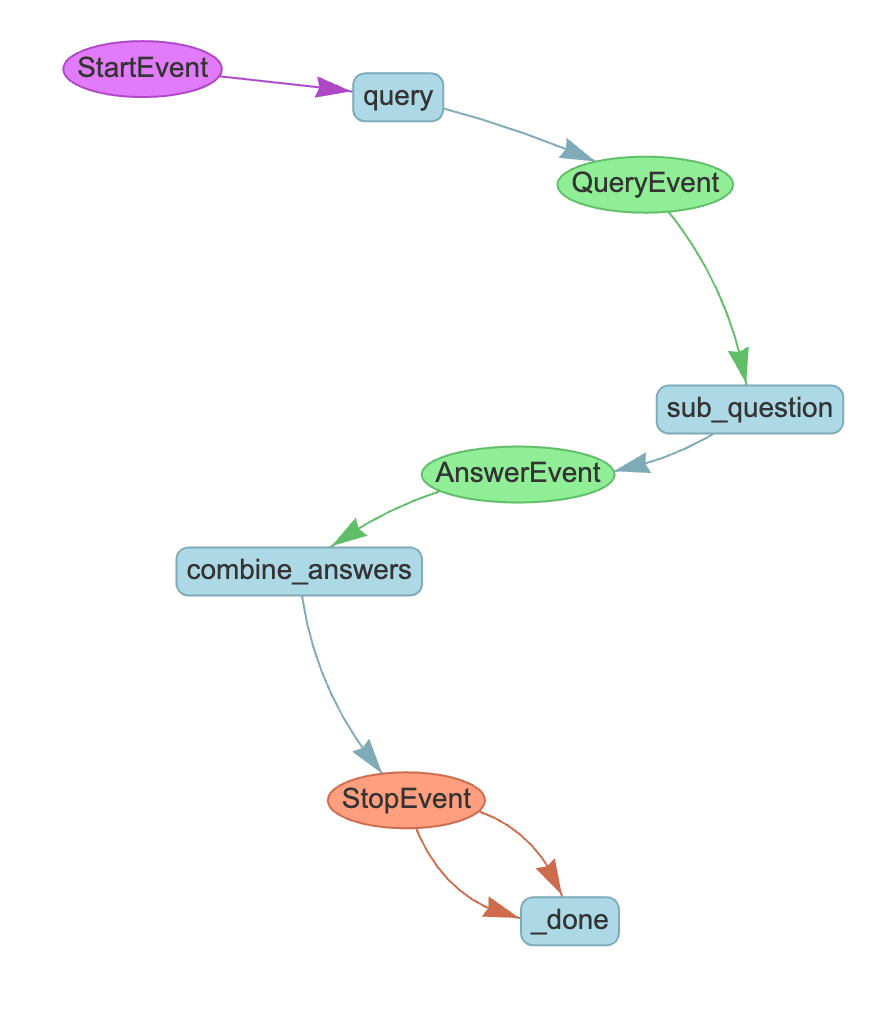

# Download data to demo

In [5]:
!mkdir -p "./data/sf_budgets/"
!wget "https://www.dropbox.com/scl/fi/xt3squt47djba0j7emmjb/2016-CSF_Budget_Book_2016_FINAL_WEB_with-cover-page.pdf?rlkey=xs064cjs8cb4wma6t5pw2u2bl&dl=0" -O "./data/sf_budgets/2016 - CSF_Budget_Book_2016_FINAL_WEB_with-cover-page.pdf"
!wget "https://www.dropbox.com/scl/fi/jvw59g5nscu1m7f96tjre/2017-Proposed-Budget-FY2017-18-FY2018-19_1.pdf?rlkey=v988oigs2whtcy87ti9wti6od&dl=0" -O "./data/sf_budgets/2017 - 2017-Proposed-Budget-FY2017-18-FY2018-19_1.pdf"
!wget "https://www.dropbox.com/scl/fi/izknlwmbs7ia0lbn7zzyx/2018-o0181-18.pdf?rlkey=p5nv2ehtp7272ege3m9diqhei&dl=0" -O "./data/sf_budgets/2018 - 2018-o0181-18.pdf"
!wget "https://www.dropbox.com/scl/fi/1rstqm9rh5u5fr0tcjnxj/2019-Proposed-Budget-FY2019-20-FY2020-21.pdf?rlkey=3s2ivfx7z9bev1r840dlpbcgg&dl=0" -O "./data/sf_budgets/2019 - 2019-Proposed-Budget-FY2019-20-FY2020-21.pdf"
!wget "https://www.dropbox.com/scl/fi/7teuwxrjdyvgw0n8jjvk0/2021-AAO-FY20-21-FY21-22-09-11-2020-FINAL.pdf?rlkey=6br3wzxwj5fv1f1l8e69nbmhk&dl=0" -O "./data/sf_budgets/2021 - 2021-AAO-FY20-21-FY21-22-09-11-2020-FINAL.pdf"
!wget "https://www.dropbox.com/scl/fi/zhgqch4n6xbv9skgcknij/2022-AAO-FY2021-22-FY2022-23-FINAL-20210730.pdf?rlkey=h78t65dfaz3mqbpbhl1u9e309&dl=0" -O "./data/sf_budgets/2022 - 2022-AAO-FY2021-22-FY2022-23-FINAL-20210730.pdf"
!wget "https://www.dropbox.com/scl/fi/vip161t63s56vd94neqlt/2023-CSF_Proposed_Budget_Book_June_2023_Master_Web.pdf?rlkey=hemoce3w1jsuf6s2bz87g549i&dl=0" -O "./data/sf_budgets/2023 - 2023-CSF_Proposed_Budget_Book_June_2023_Master_Web.pdf"

--2024-11-05 18:57:09--  https://www.dropbox.com/scl/fi/xt3squt47djba0j7emmjb/2016-CSF_Budget_Book_2016_FINAL_WEB_with-cover-page.pdf?rlkey=xs064cjs8cb4wma6t5pw2u2bl&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0967d7de1369bc80e1b4a105ad.dl.dropboxusercontent.com/cd/0/inline/Cd0tnl-4o9BsS3qD2CYMvNcn__b8finOAMzD9tRDE193pJ0OAQ8x1nk4J4F3-FOLmNVHSUjTNm0fvIxJqGcZj6vVrNQVONoEVyZizbdgHuvKAd8WHvO3CoOzGXjOoaat_3k/file# [following]
--2024-11-05 18:57:10--  https://uc0967d7de1369bc80e1b4a105ad.dl.dropboxusercontent.com/cd/0/inline/Cd0tnl-4o9BsS3qD2CYMvNcn__b8finOAMzD9tRDE193pJ0OAQ8x1nk4J4F3-FOLmNVHSUjTNm0fvIxJqGcZj6vVrNQVONoEVyZizbdgHuvKAd8WHvO3CoOzGXjOoaat_3k/file
Resolving uc0967d7de1369bc80e1b4a105ad.dl.dropboxusercontent.com (uc0967d7de1369bc80e1b4a105ad.dl.dropboxusercontent.com)... 162.125.13.15
Connecting to uc0967d7de13

# Load data and run the workflow

Just like using the built-in Sub-Question Query Engine, we create our query tools and instantiate an LLM and pass them in.

Each tool is its own query engine based on a single (very lengthy) San Francisco budget document, each of which is 300+ pages. To save time on repeated runs, we persist our generated indexes to disk.

In [6]:
import getpass

if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    print("Valid NVIDIA_API_KEY already in environment. Delete to reset")
else:
    nvapi_key = getpass.getpass("NVAPI Key (starts with nvapi-): ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

folder = "./data/sf_budgets/"
files = os.listdir(folder)

Settings.embed_model = NVIDIAEmbedding(model="nvidia/nv-embedqa-e5-v5", truncate="END")
Settings.llm = NVIDIA()

query_engine_tools = []
for file in files:
    year = file.split(" - ")[0]
    index_persist_path = f"./storage/budget-{year}/"

    if os.path.exists(index_persist_path):
        storage_context = StorageContext.from_defaults(
            persist_dir=index_persist_path
        )
        index = load_index_from_storage(storage_context)
    else:
        documents = SimpleDirectoryReader(
            input_files=[folder + file]
        ).load_data()
        index = VectorStoreIndex.from_documents(documents)
        index.storage_context.persist(index_persist_path)

    engine = index.as_query_engine()
    query_engine_tools.append(
        QueryEngineTool(
            query_engine=engine,
            metadata=ToolMetadata(
                name=f"budget_{year}",
                description=f"You can ask this tool natural-language questions about San Francisco's budget in {year}",
            ),
        )
    )

BadRequestError: Error code: 400 - {'type': 'about:blank', 'status': 400, 'title': 'Bad Request', 'detail': 'Input length 1009 exceeds maximum allowed token size 512'}

In [ ]:
engine = SubQuestionQueryEngine(timeout=120, verbose=True)
result = await engine.run(
    llm=Settings.llm,
    tools=query_engine_tools,
    query="How has the total amount of San Francisco's budget changed from 2016 to 2023?",
)

print(result)

Our debug output is lengthy! You can see the sub-questions being generated and then `sub_question()` being repeatedly invoked, each time generating a brief log of ReAct agent thoughts and actions to answer each smaller question.

You can see `combine_answers` running multiple times; these were triggered by each `AnswerEvent` but before all 8 `AnswerEvents` were collected. On its final run it generates a full prompt, combines the answers and returns the result.